# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Challenge Level 1 Overview

<p align="justify">Welcome to the EY Open Science Data Challenge 2023! This challenge consists of two levels – Level 1 and Level 2. This is the Level 1 challenge aimed at participants who are beginners or have intermediate skill sets in data science and programming. The goal of Level 1 is to predict the presence of rice crops at a given location using satellite data. By the time you complete this level, you will have developed a rice crop classification model, which can distinguish between rice and non-rice fields. 
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used two features from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and trained a logistic regression model with these features. We have extracted the VV band and VH band data from the Sentinel-1 dataset for one day (21st March 2020), with an assumption that VV and VH values for this day are representative of VV and VH values for the entire year (2020) for a given location.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    
<p align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>pc.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('b6d222b511c74821b7271a745a656ea7')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [50]:
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [51]:
crop_presence_data = crop_presence_data.rename(columns={'Latitude and Longitude': 'id', 'Class of Land': 'target'})

In [52]:
# Get the unique values in the 'target' column
unique_values = crop_presence_data['target'].unique()

# Print the unique values
print(unique_values)

['Rice' 'Non Rice']


## Predictor Variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a day (21st March 2020). </p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify"> Extract VV and VH band values for an entire year. Different land classes (e.g., agriculture, water, urban) will have different annual variability. This variability will be better than a single date for accurately identifying land classes. Please find below a demonstration of extracting data for a day (21st March 2020).

In [4]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    return vh,vv

In [35]:
###Below is the modified function

In [16]:
def get_landsat_data(latlong, time_slice, assets):
    '''
    Returns band values for a given latitude and longitude from Landsat data
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the band values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong = latlong.replace('(', '').replace(')', '').replace(' ', '').split(',')
    bbox_of_interest = (float(latlong[1]), float(latlong[0]), float(latlong[1]), float(latlong[0]))
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["landsat-c2-l2"], bbox=bbox_of_interest, datetime=time_of_interest, query={"platform": {"in": ["landsat-9"]}}
    )
    items = list(search.get_all_items())
    bands_of_interest = assets
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    band_values = {}
    for band in bands_of_interest:
        band_values[band] = data[band].astype("float").values.tolist()[0][0]
    return band_values


<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., average, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

In [58]:
## Function call to extract VV,VH Values
time_slice = "2020-11-01/2021-12-31"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['id']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

#2020-03-20/2020-03-21 #1 day
#2021-12-01/2022-04-30 #time period

100%|██████████| 600/600 [02:56<00:00,  3.39it/s]


In [59]:
## Function call to extract band values
time_slice = "2020-11-01/2021-12-31"
assets1 = ["red", "green", "blue", "nir08", "swir16", "qa_pixel"]
band_data = []
for coordinates in tqdm(crop_presence_data['id']):
    band_data.append(get_landsat_data(coordinates, time_slice, assets))
band_df = pd.DataFrame(band_data, columns=assets)


100%|██████████| 600/600 [02:44<00:00,  3.64it/s]


In [ ]:
###Below is the modified function

In [60]:
# # Rice Crop Field in An Giang, Vietnam

# lat_long = (10.4391, 105.3338) # Lat-Lon centroid location
# box_size_deg = 0.0004 # Surrounding box in degrees, yields approximately 5x5 pixel region

# min_lon = lat_long[1]-box_size_deg/2
# min_lat = lat_long[0]-box_size_deg/2
# max_lon = lat_long[1]+box_size_deg/2
# max_lat = lat_long[0]+box_size_deg/2

# bbox = (min_lon, min_lat, max_lon, max_lat)

In [61]:
# # Calculate the mean of the data across the sample region
# mean = data.mean(dim=['latitude','longitude']).compute()

In [62]:
# # Calculate RVI
# dop = (mean.vv / (mean.vv + mean.vh))
# m = 1 - dop
# rvi = (np.sqrt(dop))*((4*mean.vh)/(mean.vv + mean.vh))

In [63]:
# rvi

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [80]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data


In [81]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data.head()

,id,target,vh,vv
0,"(10.323727047081501, 105.2516346045924)",Rice,0.005097,0.034659
1,"(10.322364360592521, 105.27843410554115)",Rice,0.003479,0.103664
2,"(10.321455902933202, 105.25254306225168)",Rice,0.003644,0.023954
3,"(10.324181275911162, 105.25118037576274)",Rice,0.008874,0.067330
4,"(10.324635504740822, 105.27389181724476)",Rice,0.005963,0.047608


In [84]:
len(crop_data['id'])

600

In [85]:
# Concatenate the DataFrames along the columns axis
combined_data = pd.concat([crop_presence_data, band_df], axis=1)

# Print or further process the combined DataFrame
combined_data.head()

,id,target,red,green,blue,nir08,swir16,qa_pixel
0,"(10.323727047081501, 105.2516346045924)",Rice,11173.0,11137.0,9915.0,13913.0,13796.0,21824.0
1,"(10.322364360592521, 105.27843410554115)",Rice,12485.0,12463.0,10918.0,15027.0,12725.0,21824.0
2,"(10.321455902933202, 105.25254306225168)",Rice,10355.0,10506.0,9224.0,11591.0,8315.0,21824.0
3,"(10.324181275911162, 105.25118037576274)",Rice,11474.0,11265.0,10078.0,13750.0,13705.0,21824.0
4,"(10.324635504740822, 105.27389181724476)",Rice,10078.0,10222.0,9136.0,11544.0,8567.0,21824.0


In [86]:
# Constants for EVI calculation
G = 2.5
C1 = 6
C2 = 7.5
L = 1

# Calculate NDVI
ndvi = (combined_data["nir08"] - combined_data["red"]) / (combined_data["nir08"] + combined_data["red"])

# Calculate EVI
evi = G * ((combined_data["nir08"] - combined_data["red"]) / (combined_data["nir08"] + C1 * combined_data["red"] - C2 * combined_data["blue"] + L))

# Calculate SAVI
savi = ((combined_data["nir08"] - combined_data["red"]) / (combined_data["nir08"] + combined_data["red"] + 0.5)) * 1.5

# Calculate Albedo
albedo = 0.356 * combined_data["blue"] + 0.130 * combined_data["green"] + 0.373 * combined_data["red"] + 0.085 * combined_data["nir08"] + 0.072 * combined_data["swir16"] + 0.0018


In [87]:
vh= vh_vv_data['vh']; vv= vh_vv_data['vv']

# RV Index (RVI)
rvi =  ((1- vv / (vv+vh)) ** 2) * 4 * (vh / (vv + vh)) 

# Backscatter Coefficient Ratio (BCR)
bcr = vv / vh

# Polarization Ratio Difference (PRD)
#prd = vv - vh

# Polarization Fractional Ratio (PFR)
#pfr = (vv - vh) / (vv + vh)

# Normalized Radar Backscatter (NRB)
nrb = vv + vh

# Backscatter Anisotropy Index (BAI)
#bai = (vv - vh) / (vv + vh)


# Add indices to DataFrame
crop_data['bcr'] = bcr
#crop_data['prd'] = prd
#crop_data['pfr'] = pfr
crop_data['nrb'] = nrb
#crop_data['bai'] = bai
crop_data['rvi'] = rvi

# Display the DataFrame
print(crop_data.head())

                                         id target        vh        vv  \
0   (10.323727047081501, 105.2516346045924)   Rice  0.005097  0.034659   
1  (10.322364360592521, 105.27843410554115)   Rice  0.003479  0.103664   
2  (10.321455902933202, 105.25254306225168)   Rice  0.003644  0.023954   
3  (10.324181275911162, 105.25118037576274)   Rice  0.008874  0.067330   
4  (10.324635504740822, 105.27389181724476)   Rice  0.005963  0.047608   

         bcr       nrb       rvi  
0   6.799312  0.039756  0.008431  
1  29.795457  0.107143  0.000137  
2   6.573360  0.027598  0.009209  
3   7.587107  0.076204  0.006317  
4   7.984040  0.053571  0.005516  


In [88]:
'bcr';'nrb'

'nrb'

In [89]:
crop_data1 = crop_data.drop(crop_data.columns[0:2], axis=1)
crop_data1.head()

,vh,vv,bcr,nrb,rvi
0,0.005097,0.034659,6.799312,0.039756,0.008431
1,0.003479,0.103664,29.795457,0.107143,0.000137
2,0.003644,0.023954,6.573360,0.027598,0.009209
3,0.008874,0.067330,7.587107,0.076204,0.006317
4,0.005963,0.047608,7.984040,0.053571,0.005516


In [90]:
import pandas as pd

# Create a DataFrame with calculated variables
calculated_df = pd.DataFrame({
    'NDVI': ndvi,
    'EVI': evi,
    'SAVI': savi,
    'Albedo': albedo
})

# Display the new DataFrame
calculated_df.head()


,NDVI,EVI,SAVI,Albedo
0,0.109224,1.039533,0.163833,11320.9978
1,0.092396,0.789147,0.138592,12357.3998
2,0.056320,0.680317,0.084478,10095.8558
3,0.090232,0.811698,0.135345,11487.5318
4,0.067801,1.049241,0.101700,9938.4358


In [91]:
import pandas as pd

# Create a DataFrame with calculated variables
calculated_df = pd.DataFrame({
    'NDVI': ndvi,
    'EVI': evi,
    'SAVI': savi,
    'Albedo': albedo
})

# Display the new DataFrame
calculated_df.head()


,NDVI,EVI,SAVI,Albedo
0,0.109224,1.039533,0.163833,11320.9978
1,0.092396,0.789147,0.138592,12357.3998
2,0.056320,0.680317,0.084478,10095.8558
3,0.090232,0.811698,0.135345,11487.5318
4,0.067801,1.049241,0.101700,9938.4358


In [92]:
# Add another column "RVI" to the DataFrame
calculated_df['RVI'] = rvi

# Display the updated DataFrame
calculated_df.head()



,NDVI,EVI,SAVI,Albedo,RVI
0,0.109224,1.039533,0.163833,11320.9978,0.008431
1,0.092396,0.789147,0.138592,12357.3998,0.000137
2,0.056320,0.680317,0.084478,10095.8558,0.009209
3,0.090232,0.811698,0.135345,11487.5318,0.006317
4,0.067801,1.049241,0.101700,9938.4358,0.005516


In [93]:
calculated_df['target'] = crop_data['target']
calculated_df.head()


,NDVI,EVI,SAVI,Albedo,RVI,target
0,0.109224,1.039533,0.163833,11320.9978,0.008431,Rice
1,0.092396,0.789147,0.138592,12357.3998,0.000137,Rice
2,0.056320,0.680317,0.084478,10095.8558,0.009209,Rice
3,0.090232,0.811698,0.135345,11487.5318,0.006317,Rice
4,0.067801,1.049241,0.101700,9938.4358,0.005516,Rice


In [94]:
calculated_df['target'].count()

600

## Model Building


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [95]:
X = calculated_df.drop(columns=['target']).values
y = calculated_df ['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

In [96]:
# Get the unique values in the 'target' column
unique_values = calculated_df['target'].unique()

# Print the unique values
print(unique_values)

['Rice' 'Non Rice']


### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of VV and VH variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>
<p align="justify">Participants might explore other feature scaling techniques like Min Max Scaler, Max Absolute Scaling, Robust Scaling etc.</p>

In [100]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [84]:
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

In [28]:
from sklearn.preprocessing import RobustScaler

In [76]:
# Initialize the RobustScaler
rs = RobustScaler()
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [98]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

LogisticRegression()

In [99]:
model.score(X_train,y_train)

0.5190476190476191

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state = 0)   

#fo through all possible combinations: 9*9*9 models with 5 fold cv
# Define the parameters for grid search
dt_params = { 'max_depth':  range(1,10)         ,
             'min_samples_split':   range(2,11), #should be a larger number
             'max_leaf_nodes':    range(2,11) }

# Create a pipeline with scaling and decision tree
#pipeline = Pipeline([
    #('scaler', MinMaxScaler()),  # Replace with Standardization if needed
    #('decision_tree', DecisionTreeClassifier()) ]) 
    
grid_tree = GridSearchCV(dt, dt_params, cv=5)

grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(1, 10),
                         'max_leaf_nodes': range(2, 11),
                         'min_samples_split': range(2, 11)})

In [102]:

best_params = grid_tree.best_params_
best_score = grid_tree.best_score_

In [103]:
best_params, best_score

({'max_depth': 5, 'max_leaf_nodes': 8, 'min_samples_split': 2},
 0.9166666666666666)

In [104]:
#just checking
from sklearn.tree import DecisionTreeClassifier
dt_3 = DecisionTreeClassifier(random_state=0, max_depth=5, max_leaf_nodes= 8, min_samples_split= 2)
dt_3.fit(X_train, y_train)
dt_3.score(X_test, y_test)


0.8777777777777778

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# define function
knn = KNeighborsClassifier() # if manhattan distance required

#knn = KNeighborsClassifier() 

# define a list of parameters
param_knn = {'n_neighbors': range(3, 30, 2), 'p': [1, 2] }  # exactly the same as the input variable name. 

# range(i,j): consecutive integers i to j exclude j 
# range(i, j, s): integers from i to j exclude j, increase by s. default s=1

#apply grid search
grid_search = GridSearchCV(estimator=knn, param_grid=param_knn, scoring='accuracy')
#grid_knn = GridSearchCV(knn, param_knn, cv = 5)
grid_search.fit(X_train, y_train)

# the best hyperparameter chosen:
print(grid_search.best_params_)

# When k=25 (best case), the validation score of through CV is:
print(grid_search.best_score_)


{'n_neighbors': 13, 'p': 1}
0.8547619047619047


In [149]:
import sklearn
#sklearn.metrics.get_scorer_names()

In [ ]:
#{'sigmoid', 'poly', 'linear', 'rbf', 'precomputed'} 

In [106]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Define Function
svc = SVC(random_state = 0, kernel = 'sigmoid')

#define a list of parameters
param_svc_kernel = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000]  ,
                    'gamma': [0.0001, 0.001,0.001,0.1,1,10]     } # C = 10,000 mimics hard-margin SVM

#apply grid search
grid_svc = GridSearchCV(svc, param_svc_kernel, cv = 5, n_jobs=2)

grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid', random_state=0), n_jobs=2,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000],
                         'gamma': [0.0001, 0.001, 0.001, 0.1, 1, 10]})

In [107]:
grid_svc.best_params_
grid_svc.best_score_

0.5619047619047619

In [141]:
svm_base = SVC(random_state = 0, kernel = 'sigmoid', C= 10000, gamma= 0.0001)
svm_base.fit(X_train, y_train)
svm_base.score(X_test, y_test)

0.6333333333333333

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [108]:
insample_predictions = grid_tree.predict(X_train)

In [109]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 94.52%
              precision    recall  f1-score   support

    Non Rice       0.96      0.93      0.95       217
        Rice       0.93      0.96      0.94       203

    accuracy                           0.95       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.95      0.95      0.95       420



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [110]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

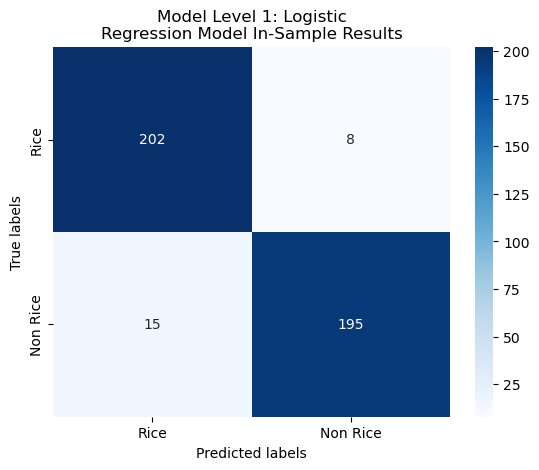

In [111]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [112]:
outsample_predictions = grid_tree.predict(X_test)

In [113]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 87.78%
              precision    recall  f1-score   support

    Non Rice       0.87      0.89      0.88        90
        Rice       0.89      0.87      0.88        90

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180



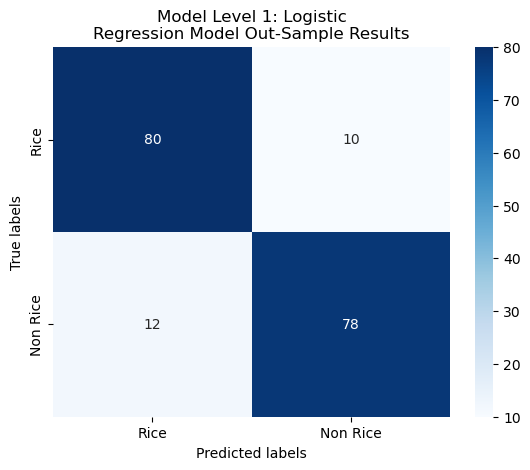

In [114]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.57</b>. This is not a very good score, so your goal is to improve this score.  

## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [116]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template_2024.csv')
test_file.head()

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [117]:
test_file = test_file.rename(columns={'Latitude and Longitude': 'id', 'Class of Land': 'target'})

In [118]:
## Get Sentinel-1-RTC Data
time_slice = "2020-11-01/2021-12-31"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['id']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
submission_vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 250/250 [01:29<00:00,  2.79it/s]


In [119]:
## Function call to extract band values
time_slice = "2020-11-01/2021-12-31"
assets1 = ["red", "green", "blue", "nir08", "swir16", "qa_pixel"]
band_data = []
for coordinates in tqdm(test_file['id']):
    band_data.append(get_landsat_data(coordinates, time_slice, assets))
band_df1 = pd.DataFrame(band_data, columns=assets)


100%|██████████| 250/250 [01:21<00:00,  3.08it/s]


In [120]:
submission_vh_vv_data.head()

,vh,vv
0,0.003942,0.051765
1,0.012979,0.025449
2,0.006942,0.181324
3,0.003958,0.011025
4,0.031076,0.193452


In [121]:
#modified

new_assest1 = []
vh1= submission_vh_vv_data['vh']; vv1= submission_vh_vv_data['vv']
new_assest1 =  ((1- vv1 / (vv1+vh1)) ** 2) * 4 * (vh1 / (vv1 + vh1)) 

In [122]:
#modified df

submission_vh_vv_data['rvi'] = new_assest1
submission_vh_vv_data.head()

,vh,vv,rvi
0,0.003942,0.051765,0.001417
1,0.012979,0.025449,0.154110
2,0.006942,0.181324,0.000201
3,0.003958,0.011025,0.073742
4,0.031076,0.193452,0.010605


In [123]:
# Constants for EVI calculation
G = 2.5
C1 = 6
C2 = 7.5
L = 1

# Calculate NDVI
ndvi1 = (band_df1["nir08"] - band_df1["red"]) / (band_df1["nir08"] + band_df1["red"])

# Calculate EVI
evi1 = G * ((band_df1["nir08"] - band_df1["red"]) / (band_df1["nir08"] + C1 * band_df1["red"] - C2 * band_df1["blue"] + L))

# Calculate SAVI
savi1 = ((band_df1["nir08"] - band_df1["red"]) / (band_df1["nir08"] + band_df1["red"] + 0.5)) * 1.5

# Calculate Albedo
albedo1 = 0.356 * band_df1["blue"] + 0.130 * band_df1["green"] + 0.373 * band_df1["red"] + 0.085 * band_df1["nir08"] + 0.072 * band_df1["swir16"] + 0.0018


In [132]:
import pandas as pd

# Create a DataFrame with calculated variables
calculated_df1 = pd.DataFrame({
    'NDVI': ndvi1,
    'EVI': evi1,
    'SAVI': savi1,
    'Albedo': albedo1,
})

# Display the new DataFrame
calculated_df1.head()


,NDVI,EVI,SAVI,Albedo
0,0.059333,-1.970093,0.088998,8544.1398
1,0.039555,-0.958995,0.059332,23044.7468
2,0.168275,0.554717,0.252408,13157.0698
3,0.069853,0.677511,0.104777,11297.2538
4,0.274755,6.680484,0.412122,8725.7148


In [135]:
# Concatenate the two DataFrames
combined_df_new = pd.concat([calculated_df1, submission_vh_vv_data], axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [127]:
# Feature Scaling 
submission_vh_vv_data = calculated_df1.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [128]:
#Making predictions
final_predictions = grid_tree.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [129]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['id'].values, 'target':final_prediction_series.values})

In [130]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Non Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Non Rice


In [131]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!pip install torch torchvision torchaudio


In [85]:
# Importing PyTorch Library for building neural networks
import torch

# Importing PyTorch's neural network module
import torch.nn as nn

# Importing PyTorch's data loading utility
from torch.utils import data

# Importing PyTorch's functional interface for neural network operations
import torch.nn.functional as F

# Importing the random library to generate random dataset
import random

# Importing the math library for mathematical operations
import math

import torch.optim as optim

from sklearn.model_selection import train_test_split

In [88]:
# Prepare features and target
X = crop_data.drop(columns=['target']).values
y = crop_data['target'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # unsqueeze to make it 2D
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [87]:
# Define the linear model
class LinearClassifier(nn.Module):
    def __init__(self, input_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

# Instantiate the model
model = LinearClassifier(input_size=X_train.shape[1])

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on test set
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_binary = (y_pred > 0.5).float()
    accuracy = (y_pred_binary == y_test_tensor).float().mean()
    print(f'Accuracy on test set: {accuracy.item():.2%}')

RuntimeError: all elements of target should be between 0 and 1

In [66]:
from sklearn.metrics import accuracy_score, classification_report

with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()  # squeeze to convert to 1D tensor and then to numpy array

# Example evaluation metrics
print("Mean Squared Error:", ((y_pred - y_test) ** 2).mean())

Mean Squared Error: 1.3901778984859448e-05


In [67]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template_2024.csv')
test_file = test_file.rename(columns={'Latitude and Longitude': 'id', 'Class of Land': 'target'})
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [68]:
## Get Sentinel-1-RTC Data
time_slice = "2020-03-20/2020-03-21"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['id']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
submission_vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


In [78]:
submission_vh_vv_data.head()

,vh,vv
0,0.003928,0.048405
1,0.016505,0.124807
2,0.036922,0.093570
3,0.002008,0.010407
4,0.063200,0.205140


In [80]:
# Feature Scaling (assuming you used the same scaler 'sc' as you did for training data)
transformed_submission_data = sc.transform(submission_vh_vv_data)

# Assuming submission_vh_vv_data has similar features as your training data, prepare it for prediction
transformed_submission_data = submission_vh_vv_data.values
X_submission_tensor = torch.tensor(transformed_submission_data, dtype=torch.float32)

# Make predictions using the trained model
with torch.no_grad():
    final_predictions_tensor = model(X_submission_tensor)
    final_predictions = final_predictions_tensor.squeeze().numpy()  # Convert to numpy array and squeeze to 1D array
    
# Convert continuous predictions to class labels using a threshold (e.g., 0.5)
threshold = 0.5
predicted_classes = (final_predictions > threshold).astype(int)

In [81]:
final_predictions

array([0.19478683, 0.26106718, 0.2380755 , 0.16251868, 0.33613625,
       0.16468859, 0.28753093, 0.2531341 , 0.1629629 , 0.2356104 ,
       0.72233605, 0.24182859, 0.20422597, 0.31548333, 0.1647527 ,
       0.15733667, 0.28168896, 0.3382653 , 0.37120038, 0.42022255,
       0.16770625, 0.34125024, 0.24055956, 0.2634213 , 0.25361937,
       0.36207303, 0.22031735, 0.3765336 , 0.17182414, 0.35345048,
       0.45187482, 0.22801712, 0.20375425, 0.31496036, 0.32614306,
       0.24687472, 0.26679987, 0.16479169, 0.21200028, 0.22312821,
       0.37017363, 0.18403569, 0.5491683 , 0.36851743, 0.2720564 ,
       0.20127146, 0.25870478, 0.21940468, 0.26308036, 0.26210338,
       0.3170351 , 0.41066256, 0.3147378 , 0.3337474 , 0.5694879 ,
       0.3145937 , 0.2070916 , 0.24319129, 0.31387204, 0.16985554,
       0.19413784, 0.20561665, 0.23821239, 0.16637823, 0.21470724,
       0.18178628, 0.16550745, 0.20283787, 0.41563752, 0.22813089,
       0.31869575, 0.17596154, 0.44726023, 0.24919583, 0.33878

In [74]:
# Convert predictions to a pandas Series
final_prediction_series = pd.Series(final_predictions)

# Combining the results into a DataFrame
submission_df = pd.DataFrame({'id': test_file['id'].values, 'target': final_prediction_series.values})

In [75]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)